# IBM Advertising Bias

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
bias_table = pd.read_csv("new_table.csv")

In [2]:
print(bias_table.head())

   college_educated  homeowner gender    age income  true_conversion  \
0                 1          1      F  55-64  <100K                0   
1                 1          1      F  55-64  >100K                0   
2                 1          1      F  55-64  <100K                0   
3                 1          1      F  55-64  >100K                0   
4                 1          1      F  55-64  <100K                0   

   predicted_conversion  predicted_probability  
0                     0               0.002120  
1                     0               0.001710  
2                     0               0.008420  
3                     0               0.004488  
4                     0               0.001874  


In [3]:
bias_table = bias_table[bias_table['age'] != "Unknown"]

In [4]:
len(bias_table)

2390

In [5]:
type(bias_table)
len(bias_table)

2390

In [6]:
bias_table.to_csv('removed_unknowns.csv', encoding='utf-8')

In [7]:
from sklearn.metrics import confusion_matrix

In [8]:
confusion_matrix(bias_table['true_conversion'],bias_table['predicted_conversion'])

array([[2381,    3],
       [   5,    1]])

The top row is true positive, false positive and the bottom is false negative, true negative. 

Trying to get a list of all the instances where "predicted_conversion" and "true_conversion" in the dataframe bias_table are not equal to each other. 

In [9]:
df_false_positive = bias_table[(bias_table['predicted_conversion'] == 1)&(bias_table['true_conversion']==0)]
df_false_negative = bias_table[(bias_table['predicted_conversion'] == 0)&(bias_table['true_conversion']==1)]


In [10]:
outliers = pd.concat([df_false_positive, df_false_negative])

In [11]:
print(outliers)

      college_educated  homeowner gender    age income  true_conversion  \
228                  1          0      F  55-64  >100K                0   
759                  1          1      M  55-64  <100K                0   
1080                 1          0      F  55-64  <100K                0   
748                  1          1      M  55-64  <100K                1   
1277                 1          0      M  55-64  >100K                1   
1844                 1          0      M  55-64  <100K                1   
2280                 1          1      F  55-64  >100K                1   
2332                 1          0      F  55-64  <100K                1   

      predicted_conversion  predicted_probability  
228                      1               0.421186  
759                      1               0.583358  
1080                     1               0.365767  
748                      0               0.006888  
1277                     0               0.002424  
1844        

In [12]:
len(outliers)

8

## Kernel Density Estimate for Predicted Probability and Predicted Conversion

In [13]:
predicted_converted = bias_table[bias_table['predicted_conversion'] == 1]
predicted_nonconverted = bias_table[bias_table['predicted_conversion'] == 0]


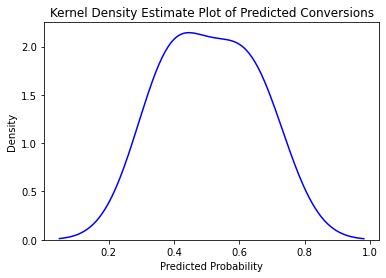

In [14]:
prediction_prob_convert = list(predicted_converted['predicted_probability'])
ax = sns.kdeplot(data=prediction_prob_convert, color="blue")
ax.set(xlabel='Predicted Probability', ylabel='Density', title="Kernel Density Estimate Plot of Predicted Conversions")
plt.show()

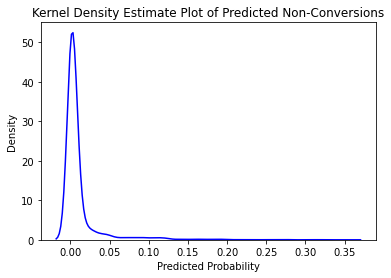

In [15]:
prediction_prob_nonconvert = list(predicted_nonconverted['predicted_probability'])
ax = sns.kdeplot(data=prediction_prob_nonconvert, color="blue")
ax.set(xlabel='Predicted Probability', ylabel='Density', title="Kernel Density Estimate Plot of Predicted Non-Conversions")
plt.show()

## Kernel Density Estimate for Predicted Probability and True Conversion

In [16]:
true_converted = bias_table[bias_table['true_conversion'] == 1]
true_nonconverted = bias_table[bias_table['true_conversion'] == 0]
len(true_converted)
len(true_nonconverted)

2384

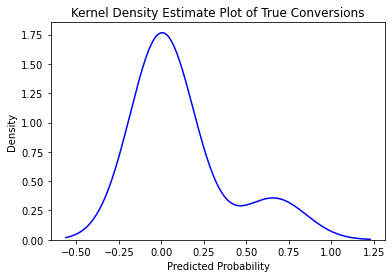

In [17]:
prediction_prob_trueconvert = list(true_converted['predicted_probability'])
ax = sns.kdeplot(data=prediction_prob_trueconvert, color="blue")
ax.set(xlabel='Predicted Probability', ylabel='Density', title="Kernel Density Estimate Plot of True Conversions")
plt.show()

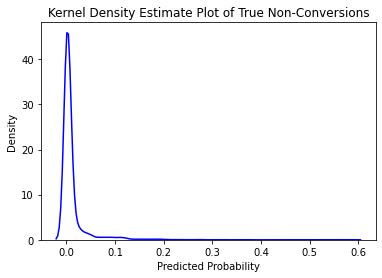

In [18]:
prediction_prob_truenonconvert = list(true_nonconverted['predicted_probability'])
ax = sns.kdeplot(data=prediction_prob_truenonconvert, color="blue")
ax.set(xlabel='Predicted Probability', ylabel='Density', title="Kernel Density Estimate Plot of True Non-Conversions")
plt.show()

## Feature Importance

advert_data = bias_table.drop(['predicted_probability'], axis=1)
predicted_prob = bias_table['predicted_probability']

import numpy as np
import pandas as pd
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

advert_data_train, advert_data_test, predicted_prob_train, predicted_prob_test = train_test_split(advert_data, predicted_prob, test_size=0.25, random_state=np.random.seed())

In [19]:
type(bias_table)

pandas.core.frame.DataFrame

 .dtype()

ValueError was raised due to multiple data formats in bias_table. 

rf = RandomForestRegressor(n_estimators=150)
rf.fit(advert_data_train, predicted_prob_train)

In [20]:
bias_table.dtypes

college_educated           int64
homeowner                  int64
gender                    object
age                       object
income                    object
true_conversion            int64
predicted_conversion       int64
predicted_probability    float64
dtype: object

In [21]:
bias_table['age'].value_counts()

55-64    2311
45-54      39
25-34      37
18-24       3
Name: age, dtype: int64

In [22]:
bias_table['income'].value_counts()

<100K    1215
>100K    1175
Name: income, dtype: int64

In [23]:
bias_table['gender'].value_counts()

F    1552
M     838
Name: gender, dtype: int64

In order to move past the ValueError, we will be converting the objects in the columns: age, income, and gender, into the following integers. 

For age, 0 will be assigned to 18-24, 1 to 25-34, 2 to 45-54, 3 to 55-64. 

For income, <100K will be assigned to 0 and >100K to 1.

For gender, F will be assigned to 0 and M to 1. 

In [24]:
bias_table['age'] = bias_table['age'].replace(['18-24', '25-34', '45-54', '55-64'], [0, 1, 2, 3])

In [25]:
bias_table.dtypes

college_educated           int64
homeowner                  int64
gender                    object
age                        int64
income                    object
true_conversion            int64
predicted_conversion       int64
predicted_probability    float64
dtype: object

In [26]:
bias_table['gender'] = bias_table['gender'].replace(['F', 'M'], [0, 1])

In [27]:
bias_table['income'] = bias_table['income'].replace(['<100K', '>100K'], [0, 1])

In [28]:
bias_table.head()

,college_educated,homeowner,gender,age,income,true_conversion,predicted_conversion,predicted_probability
0,1,1,0,3,0,0,0,0.002120
1,1,1,0,3,1,0,0,0.001710
2,1,1,0,3,0,0,0,0.008420
3,1,1,0,3,1,0,0,0.004488
4,1,1,0,3,0,0,0,0.001874


In [29]:
advert_data = bias_table.drop(['predicted_probability', 'predicted_conversion', 'true_conversion'], axis=1)
predicted_prob = bias_table['predicted_probability']

In [30]:
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [31]:
advert_data_train, advert_data_test, predicted_prob_train, predicted_prob_test = train_test_split(advert_data, predicted_prob, test_size=0.25, random_state=np.random.seed())

In [32]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(advert_data_train, predicted_prob_train)

RandomForestRegressor(n_estimators=150)

Text(0.5, 0, 'Feature Importance')

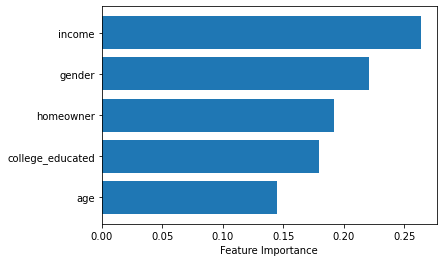

In [33]:
sort = rf.feature_importances_.argsort()
plt.barh(bias_table.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

## Showing Distributions for Age, Gender, College Educated, Income, and Home Ownership

In [34]:
dist_age = bias_table['age'].value_counts()
dist_age.index

Int64Index([3, 2, 1, 0], dtype='int64')

In [35]:
dist_age = dist_age.rename({0: '18-24', 1: '25-34', 2: '45-54', 3: '55-64'})
print(dist_age)

55-64    2311
45-54      39
25-34      37
18-24       3
Name: age, dtype: int64


In [36]:
dist_gender = bias_table['gender'].value_counts()
dist_gender.index
dist_gender = dist_gender.rename({0: 'Females', 1: 'Males'})
print(dist_gender)

Females    1552
Males       838
Name: gender, dtype: int64


In [37]:
dist_college = bias_table['college_educated'].value_counts()
dist_college.index
dist_college = dist_college.rename({0: 'No', 1: 'Yes'})
print(dist_college)

Yes    2268
No      122
Name: college_educated, dtype: int64


In [38]:
dist_income = bias_table['income'].value_counts()
dist_income.index
dist_income = dist_income.rename({0: 'Under 100K', 1: 'Over 100K'})
print(dist_income)

Under 100K    1215
Over 100K     1175
Name: income, dtype: int64


In [39]:
dist_homeowner = bias_table['homeowner'].value_counts()
dist_homeowner.index
dist_homeowner = dist_homeowner.rename({0: 'No', 1: 'Yes'})
print(dist_homeowner)

Yes    2058
No      332
Name: homeowner, dtype: int64


In [40]:
dist_age.values

array([2311,   39,   37,    3])

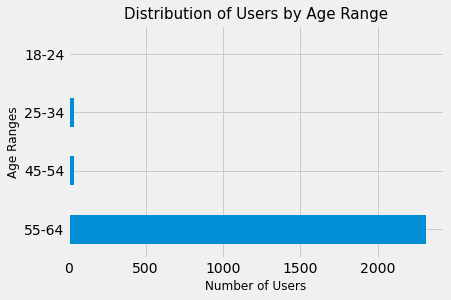

<Figure size 432x288 with 0 Axes>

In [43]:
dist_age.sort_index()
plt.style.use('fivethirtyeight')
ax = dist_age.plot(kind='barh')
plt.title('Distribution of Users by Age Range', fontsize=15)
plt.ylabel('Age Ranges', fontsize=12)
plt.xlabel('Number of Users', fontsize=12)
plt.show()
plt.savefig('dist_users_age.jpg')

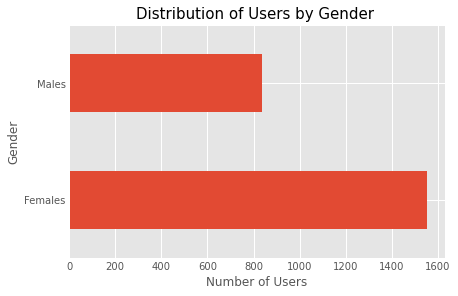

<Figure size 432x288 with 0 Axes>

In [44]:
dist_gender.sort_index()
plt.style.use('ggplot')
dist_gender.plot(kind='barh')
plt.title('Distribution of Users by Gender ', fontsize=15)
plt.ylabel('Gender')
plt.xlabel('Number of Users')
plt.show()
plt.savefig('dist_users_gender.jpg')

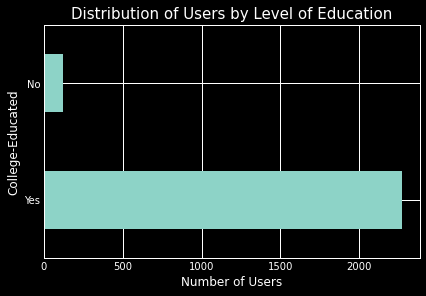

<Figure size 432x288 with 0 Axes>

In [45]:
dist_college.sort_index()
plt.style.use('dark_background')
dist_college.plot(kind='barh')
plt.title('Distribution of Users by Level of Education', fontsize=15)
plt.ylabel('College-Educated')
plt.xlabel('Number of Users')
plt.show()
plt.savefig('dist_users_college.jpg')

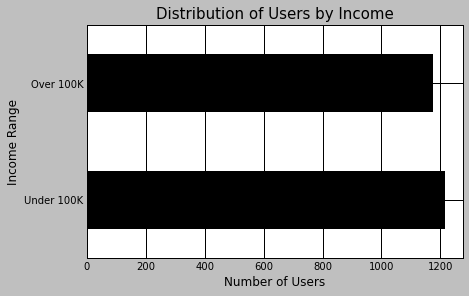

<Figure size 432x288 with 0 Axes>

In [54]:
dist_income.sort_index()
plt.style.use('grayscale')
dist_income.plot(kind='barh')
plt.title('Distribution of Users by Income', fontsize=15)
plt.ylabel('Income Range')
plt.xlabel('Number of Users')
plt.show()
plt.savefig('dist_users_income.jpg')

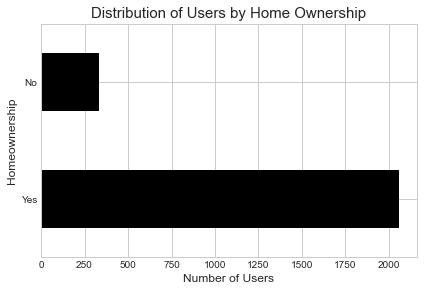

<Figure size 432x288 with 0 Axes>

In [55]:
dist_homeowner.sort_index()
plt.style.use('seaborn-whitegrid')
dist_homeowner.plot(kind='barh')
plt.title('Distribution of Users by Home Ownership', fontsize=15)
plt.ylabel('Homeownership')
plt.xlabel('Number of Users')
plt.show()
plt.savefig('dist_users_homeowner.jpg')